In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Predictive Regression Modeling Workflow

## Students Will Be Able To
 - Understand the basic outline of a predictive modeling workflow
 - Describe the similarities and differences between this predictive regression workflow and the previous (Mod 2) inferential regression workflow

## Business Understanding and Data Understanding

This dataset was downloaded from [Kaggle](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho) and contains information about **used car sale listings**.  We are trying to **predict the price** associated with the listing.

### Features (as described on Kaggle)
 - `Car_Name`: The name of the car
 - `Year`: The year in which the car was bought
 - `Selling_Price`: The price the owner wants to sell the car at
 - `Present_Price`: The current ex-showroom price of the car
 - `Kms_Driven`: The distance completed by the car in km
 - `Fuel_Type`: The fuel type of the car (`Petrol`, `Diesel`, or Other)
 - `Seller_Type`: Whether the seller is a dealer or an individual
 - `Transmission`: Whether the car is manual or automatic
 - `Owner`: The number of owners the car has previously had

Looking at the original website, it looks like the prices are listed in lakhs, meaning hundreds of thousands of rupees.

In [2]:
df = pd.read_csv("cars.csv")

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [5]:
df.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

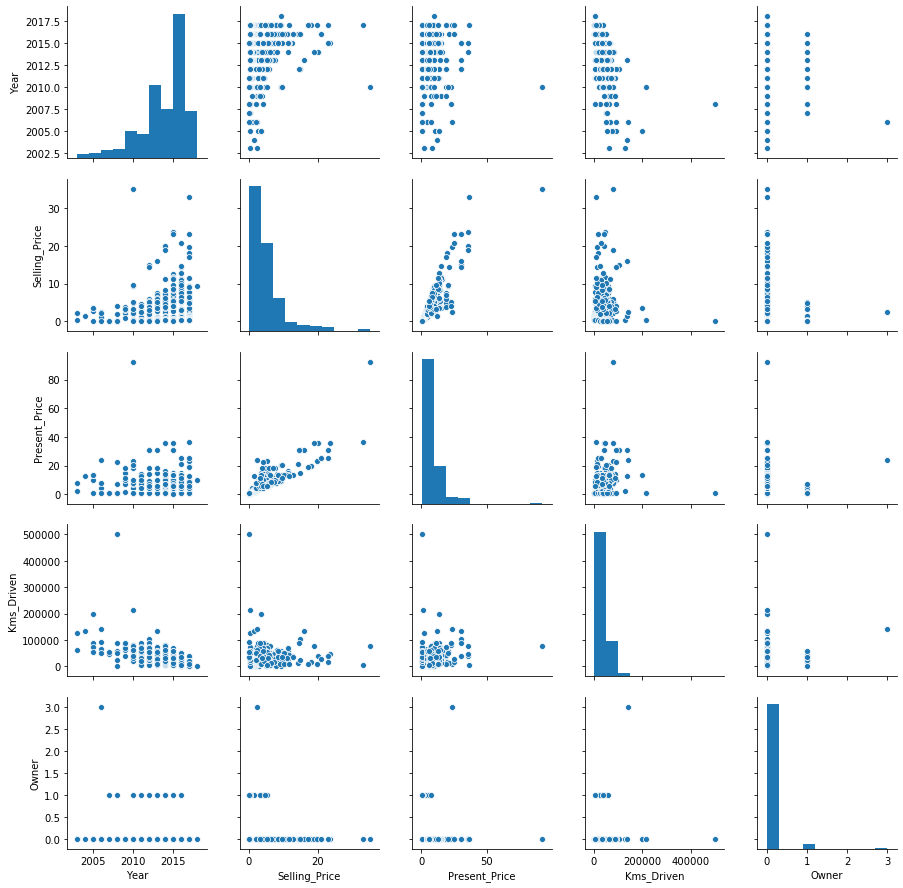

In [6]:
sns.pairplot(df);

### *Compare and Contrast: Business Understanding and Data Understanding*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Data understanding process is basically the same, trying to understand:
- what a record represents
- which attribute is the target for the business purpose (separate into y and X)
- what kinds of features we have
- the relationship of the features to the target
"""

## Train-Test Split

Before performing any preprocessing or modeling, set aside a holdout test set

In [7]:
X = df.drop("Selling_Price", axis=1)
y = df["Selling_Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### *Compare and Contrast: Train-Test Split*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
For inferential, we just used all available rows every time we fit
the model (i.e. there was no train-test split)

Now, we are further splitting the rows (both target/y and features/X)
into train and test sets (i.e. performing a train-test split)
"""

## Baseline Model: Linear Regression with Numeric Features Only

We have four numeric features (`Year`, `Present_Price`, `Kms_Driven`, and `Owner`) and four non-numeric features (`Car_Name`, `Fuel_Type`, `Seller_Type`, `Transmission`).  Before doing any of the engineering work to be able to use those non-numeric features, let's just try using the numeric ones

In [8]:
lin_reg_model = LinearRegression()

X_train_numeric = X_train[["Year", "Present_Price", "Kms_Driven", "Owner"]].copy()

In [9]:
baseline_cross_val_score = cross_val_score(lin_reg_model, X_train_numeric, y_train)
baseline_cross_val_score

array([0.67168559, 0.75626366, 0.88591659, 0.79241643, 0.84299344])

Ok, not too bad, we are getting somewhere between 0.67 and 0.89 r-squared for a linear regression with just the numeric features

### *Compare and Contrast: Baseline Model*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Similarities:
- In both cases, we are doing a regression analysis and looking
  at r-squared to see how much of the variance is explained
- Also in both cases we have the concept of a baseline model whose
  performance we'll use to evaluate the final model

Differences:
- For inferential, we typically used StatsModels. Now we're using
  SciKit Learn.
- For inferential, we looked at r-squared for *all* of the data. Now
  we're looking at r-squared for several different splits of the data
- For inferential, we investigated the feature coefficients and
  p-values. Now we aren't looking at those at all.
- For inferential, we did a bunch of assumption checks. Now we're only
  looking at r-squared
- For inferential, we started with just one numeric feature, because
  we were concerned about multicollinearity. Now we went ahead and 
  added all numeric features to create the baseline model
"""

## Add One-Hot Encoded Features

Let's see if adding in some of those non-numeric features helps

In [10]:
# resetting the index so we can concatenate the one-hot encoded dfs more easily
X_train_all_features = X_train.copy().reset_index().drop("index", axis=1)

In [11]:
def encode_and_concat_feature_train(X_train_all_features, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train_all_features[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train_all_features = encode_and_concat_feature(X_train_all_features, feature_name, ohe)
    
    return ohe, X_train_all_features

In [12]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0])
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [13]:
# we will need each of these encoders later for transforming the test data

fuel_type_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Fuel_Type")
seller_type_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Seller_Type")
transmission_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Transmission")
# putting car name at the end just because there are the most categories
car_name_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Car_Name")

In [14]:
X_train_all_features.columns

Index(['Year', 'Present_Price', 'Kms_Driven', 'Owner', 'CNG', 'Diesel',
       'Petrol', 'Dealer', 'Individual', 'Automatic', 'Manual', '800',
       'Activa 3g', 'Bajaj  ct 100', 'Bajaj Avenger 150',
       'Bajaj Avenger 150 street', 'Bajaj Avenger 220',
       'Bajaj Avenger 220 dtsi', 'Bajaj Avenger Street 220',
       'Bajaj Discover 100', 'Bajaj Discover 125', 'Bajaj Dominar 400',
       'Bajaj Pulsar 135 LS', 'Bajaj Pulsar 150', 'Bajaj Pulsar 220 F',
       'Bajaj Pulsar NS 200', 'Bajaj Pulsar RS200', 'Hero  Ignitor Disc',
       'Hero Extreme', 'Hero Glamour', 'Hero Honda Passion Pro', 'Hero Hunk',
       'Hero Passion Pro', 'Hero Passion X pro', 'Hero Splender Plus',
       'Hero Splender iSmart', 'Hero Super Splendor', 'Honda Activa 4G',
       'Honda CB Hornet 160R', 'Honda CB Shine', 'Honda CB Unicorn',
       'Honda CB twister', 'Honda CBR 150', 'Honda Karizma', 'Hyosung GT250R',
       'KTM 390 Duke ', 'KTM RC200', 'KTM RC390', 'Royal Enfield Bullet 350',
       'Royal En

In [15]:
X_train_all_features

,Year,Present_Price,Kms_Driven,Owner,CNG,Diesel,Petrol,Dealer,Individual,Automatic,...,innova,jazz,land cruiser,omni,ritz,swift,sx4,verna,wagon r,xcent
0,2017,0.84,5000,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015,14.79,12900,0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015,0.32,35000,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015,13.60,21780,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,5.90,14465,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2013,0.57,18000,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,2011,12.48,45000,0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222,2014,3.45,16500,1,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,2011,10.00,69341,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### *Compare and Contrast: One-Hot Encoding*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
In both cases we are creating dummy columns to represent categorical
data as numbers, so that the categorical features can hopefully
improve the performance of our model

For inferential, you might have used pd.get_dummies, whereas here we
are using a OneHotEncoder

For inferential, we dropped one category to avoid perfect
multicollinearity. Now we aren't dropping any categories.
"""

## Linear Regression with More Features

In [16]:
lin_reg_model = LinearRegression()

print("Old:", baseline_cross_val_score)
print("New:", cross_val_score(lin_reg_model, X_train_all_features, y_train))

Old: [0.67168559 0.75626366 0.88591659 0.79241643 0.84299344]
New: [ 5.37672694e-01 -7.38091761e+12  9.16586477e-01  7.58859065e-01
  7.52699829e-01]


That looks worse.  What if we don't use the car name, and just use the categories with 1-3 values?

In [17]:
X_train_all_except_car_name = X_train_all_features[[
                    "Year",
                    "Present_Price",
                    "Kms_Driven",
                    "Owner",
                    "CNG",
                    "Diesel",
                    "Petrol",
                    "Dealer",
                    "Individual",
                    "Automatic",
                    "Manual"
                ]].copy()
X_train_all_except_car_name

,Year,Present_Price,Kms_Driven,Owner,CNG,Diesel,Petrol,Dealer,Individual,Automatic,Manual
0,2017,0.84,5000,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,2015,14.79,12900,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,2015,0.32,35000,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,2015,13.60,21780,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,2015,5.90,14465,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
220,2013,0.57,18000,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
221,2011,12.48,45000,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
222,2014,3.45,16500,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0
223,2011,10.00,69341,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [18]:
lin_reg_model = LinearRegression()

print("Old:", baseline_cross_val_score)
print("New:", cross_val_score(lin_reg_model, X_train_all_except_car_name, y_train))

Old: [0.67168559 0.75626366 0.88591659 0.79241643 0.84299344]
New: [0.71773298 0.65008625 0.92349676 0.81151078 0.88264199]


Ok, adding these categories improved r-squared for 4 out of 5 subsamples compared to just having numeric features, so let's keep them for our linear regression model

In [19]:
best_linreg_cross_val_score = cross_val_score(lin_reg_model, X_train_all_except_car_name, y_train)

### *Compare and Contrast: Linear Regression with More Features*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Overall, very similar answer to the baseline model question

We are doing the same general workflow of looking at metrics,
doing some feature engineering to try to improve the metrics,
then investigating whether it worked

Again, we're using a different Python library (SciKit Learn vs.
StatsModels) and looking at different metrics
"""

## Try a More Advanced Model

It depends on our business case whether these numbers are sufficient.  We are explaining approximately somewhere between 65% and 92% of the variance in the sale price.  But let's try a more complicated model.

First, just using the X_train values used in the linear regression:

In [20]:
random_forest_regressor_model_1 = RandomForestRegressor(n_estimators=10, random_state=42)

print("Old:", best_linreg_cross_val_score)
print("New:", cross_val_score(random_forest_regressor_model_1, X_train_all_except_car_name, y_train))

Old: [0.71773298 0.65008625 0.92349676 0.81151078 0.88264199]
New: [0.83102658 0.66532476 0.90650579 0.81714334 0.92862009]


Ok, this more-sophisticated model is performing slightly better on 4 of 5 subsamples than the best linear regression score.  Let's see what happens if we add the car names back in:

In [21]:
random_forest_regressor_model_2 = RandomForestRegressor(n_estimators=10, random_state=42)

print("Old:", cross_val_score(random_forest_regressor_model_1, X_train_all_except_car_name, y_train))
print("New:", cross_val_score(random_forest_regressor_model_2, X_train_all_features, y_train))

Old: [0.83102658 0.66532476 0.90650579 0.81714334 0.92862009]
New: [0.8120682  0.7237103  0.90434184 0.80154837 0.92665771]


Only one of the subsamples improved with adding this feature, and everything else got worse

## Hyperparameter Tuning the More Advanced Model

Let's add some more "power" to the random forest regressor, since it's running reasonably quickly right now

In [22]:
random_forest_regressor_model_3 = RandomForestRegressor(n_estimators=1000, random_state=42)

print("Old:", cross_val_score(random_forest_regressor_model_1, X_train_all_except_car_name, y_train))
print("New:", cross_val_score(random_forest_regressor_model_3, X_train_all_except_car_name, y_train))

Old: [0.83102658 0.66532476 0.90650579 0.81714334 0.92862009]
New: [0.85347083 0.72854389 0.90506631 0.83936817 0.93520377]


That marginally improved 4 of the 5 subsamples (but was significantly slower to run).  Let's try including the car name again:

In [23]:
random_forest_regressor_model_4 = RandomForestRegressor(n_estimators=1000, random_state=42)

print("Old:", cross_val_score(random_forest_regressor_model_3, X_train_all_except_car_name, y_train))
print("New:", cross_val_score(random_forest_regressor_model_4, X_train_all_features, y_train))

Old: [0.85347083 0.72854389 0.90506631 0.83936817 0.93520377]
New: [0.82470832 0.71709424 0.89251424 0.8456903  0.93846238]


Again, that didn't really seem to help.  So if we're stopping right now, we can say that the third random forest regressor is the best model.

### *Compare and Contrast: Hyperparameter Tuning*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
For inference, we only ever used a linear regression model.  Now
we're using a different model called a "random forest regressor"
that also does regression

We are also seeing something called *hyperparameters* for the first
time, which are attributes of the model itself

In other words, in Mod 2:
- Model was chosen for you (linear regression)
- Model hyperparameters were chosen for you (defaults from
  StatsModels)
- You chose your own features (including OHE features)

Now, in Mod 3:
- You choose the model (linear regression, random forest
  regressor, etc.)
- You choose the hyperparameters (we'll learn more about
  these options soon)
- You choose the features (including OHE features)
"""

## Model Evaluation

Now that we have chosen a best model, let's use the holdout set to see how well the final model does

### Preprocessing to Use Test Data
First, perform all of the same transformations on the test X that were performed on the train X

In [24]:
X_test_all_except_car_name = X_test.reset_index().drop(["index", "Car_Name"], axis=1)

# fuel_type_ohe, seller_type_ohe, and transmission_ohe were fitted on the training data
X_test_all_except_car_name = encode_and_concat_feature(X_test_all_except_car_name, "Fuel_Type", fuel_type_ohe)
X_test_all_except_car_name = encode_and_concat_feature(X_test_all_except_car_name, "Seller_Type", seller_type_ohe)
X_test_all_except_car_name = encode_and_concat_feature(X_test_all_except_car_name, "Transmission", transmission_ohe)

X_test_all_except_car_name

,Year,Present_Price,Kms_Driven,Owner,CNG,Diesel,Petrol,Dealer,Individual,Automatic,Manual
0,2016,0.57,24000,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2016,13.60,10980,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,2012,9.40,60000,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,2011,0.57,35000,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,2013,18.61,40001,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
71,2011,8.01,50000,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
72,2016,7.90,28569,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
73,2015,7.27,40534,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
74,2012,4.43,23709,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


### Fitting and Scoring Final Model

Fit our best model on all of the training data

In [25]:
random_forest_regressor_model_3.fit(X_train_all_except_car_name, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Score our best model on the test data

In [26]:
random_forest_regressor_model_3.score(X_test_all_except_car_name, y_test)

0.9706072528266274

That's pretty good!  We have a model that is able to explain 97% of the variance in the car sale list prices

### Fitting and Scoring Baseline Model

Let's compare that to the baseline model:

In [27]:
lin_reg_model.fit(X_train_numeric, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
X_test_numeric = X_test[["Year", "Present_Price", "Kms_Driven", "Owner"]].copy()

lin_reg_model.score(X_test_numeric, y_test)

0.8511933884353676

So, our r-squared has improved from a baseline of 85% to 97%.

### Other Metrics

To report something more applicable to a business audience, let's calculate the [root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) using the [metrics submodule of scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [29]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, random_forest_regressor_model_3.predict(X_test_all_except_car_name))
mse

0.8075452595118476

In [30]:
rmse = np.sqrt(mse)
rmse

0.8986352204937483

To interpret this: on average, our prediction of `Selling_Price` is off (either too high or too low) by about 0.9 lakh, i.e. about 90,000 rupees (about 1200 USD)

Let's compare that to the baseline model:

In [31]:
baseline_mse = mean_squared_error(y_test, lin_reg_model.predict(X_test_numeric))
np.sqrt(baseline_mse)

2.021968848419496

So, the baseline model was off by about 2 lakh, i.e. about 200,000 rupees (about 2600 USD)

### Visualization of Model Performance

Also, here is a plot that shows the actual vs. predicted prices:

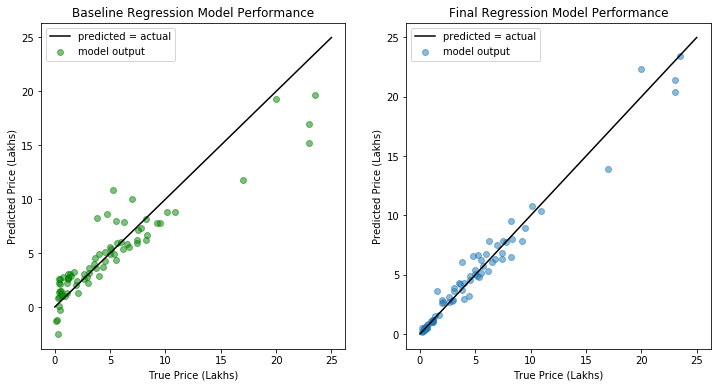

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# Customize which model is actually being plotted
axes[0].set_title("Baseline Regression Model Performance")
axes[0].scatter(y_test, lin_reg_model.predict(X_test_numeric),
                alpha=0.5, label="model output", color="green")

axes[1].set_title("Final Regression Model Performance")
axes[1].scatter(y_test, random_forest_regressor_model_3.predict(X_test_all_except_car_name),
                alpha=0.5, label="model output")

# Same setup for both plots (x and y labels, line showing y=x)
y_equals_x = np.linspace(0, 25)
for ax in axes:
    ax.set_xlabel("True Price (Lakhs)")
    ax.set_ylabel("Predicted Price (Lakhs)")
    ax.plot(y_equals_x, y_equals_x, label="predicted = actual", color="black")
    ax.legend()

### *Compare and Contrast: Model Evaluation*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Same overall process of showing improvement over a baseline model,
in terms of r-squared as well as visualizing the model performance

Potentially the same in terms of reporting multiple metrics, e.g.
RMSE, in order to communicate model results further (although we
were optimizing for r-squared in both cases, not RMSE)

Different process related to train-test split:
- Preprocessing training data
- Fitting on training data
- Cross-validation on training data
- Preprocessing test data (with the same encoders used on the training data)
- Evaluating on test data

Whereas in Mod 2, we preprocessed all records at the same time,
fit on all records, evaluated on all records
"""